<a href="https://colab.research.google.com/github/asigalov61/SuperPiano/blob/master/Super_Piano_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Music Transformer
## Generating Music with Long-Term structure
### Based on 2019 ICLR paper by Cheng-Zhi Anna Huang, Google Brain and Damon Gwinn's code/repo https://github.com/gwinndr/MusicTransformer-Pytorch

Huge thanks go out to the following people who contributed the code/repos used in this colab. Additional contributors are listed in the code as well.

1) Kevin-Yang https://github.com/jason9693/midi-neural-processor

2) gudgud96 for fixing Kevin's MIDI Encoder properly https://github.com/gudgud96

2) jinyi12, Zac Koh, Akamight, Zhang https://github.com/COMP6248-Reproducability-Challenge/music-transformer-comp6248

Thank you so much for your hard work and for sharing it with the world :)


### Setup Environment and Dependencies. Check GPU.

In [2]:
#@title Check if GPU (driver) is avaiiable (you do not want to run this on CPU, trust me)
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Nov__3_21:07:56_CDT_2017
Cuda compilation tools, release 9.1, V9.1.85
Tue Mar 14 17:30:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:04:00.0 Off |                    0 |
| N/A   32C    P0    32W / 250W |   1998MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+---

In [3]:
#@title Clone/Install all dependencies
!git clone https://github.com/asigalov61/midi-neural-processor
!git clone https://github.com/asigalov61/MusicTransformer-Pytorch
!pip install tqdm
!pip install progress
!pip install pretty-midi
!pip install pypianoroll
!pip install matplotlib
!pip install librosa
!pip install scipy
!pip install pillow
!apt install fluidsynth #Pip does not work for some reason. Only apt works
!pip install midi2audio
!pip install mir_eval
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 /content/font.sf2

Cloning into 'midi-neural-processor'...
remote: Enumerating objects: 26, done.
remote: Total 26 (delta 0), reused 0 (delta 0), pack-reused 26
Unpacking objects: 100% (26/26), done.
Cloning into 'MusicTransformer-Pytorch'...
remote: Enumerating objects: 385, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 385 (delta 99), reused 84 (delta 84), pack-reused 247
Receiving objects: 100% (385/385), 100.31 KiB | 689.00 KiB/s, done.
Resolving deltas: 100% (200/200), done.
    100% |████████████████████████████████| 81kB 6.3MB/s eta 0:00:01
  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
  Using cached https://files.pythonhosted.org/packages/d9/5a/e7c31adbe875f2abbb91bd84cf2dc52d792b5a01506781dbcf25c91daf11/six-1.16.0-py2.py3-none-any.whl
  Running setup.py bdist_wheel for scandir ... done
  Stored in directory: /home/zan

In [11]:
#@title Import all needed modules
import numpy as np
import pickle
import os
import sys
import math
import random
# For plotting
import pypianoroll
from pypianoroll import Multitrack, Track
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use('SVG')
#%matplotlib inline
#matplotlib.get_backend()
import mir_eval.display
import librosa
import librosa.display
# For rendering output audio
import pretty_midi
from midi2audio import FluidSynth
# from google.colab import output
from IPython.display import display, Javascript, HTML, Audio

In [12]:
#@title (Optional) Pre-trained models download (2 models trained for 100 epochs to 1.968 FLoss and 0.420 acc)
!mkdir /content/MusicTransformer-Pytorch/rpr
!mkdir /content/MusicTransformer-Pytorch/rpr/results
%cd /content/MusicTransformer-Pytorch/rpr/results
!wget 'https://superpiano.s3-us-west-1.amazonaws.com/SuperPiano3models.zip'
!unzip SuperPiano3models.zip
%cd /content/MusicTransformer-Pytorch/

mkdir: cannot create directory ‘/content/MusicTransformer-Pytorch/rpr’: No such file or directory
mkdir: cannot create directory ‘/content/MusicTransformer-Pytorch/rpr/results’: No such file or directory
[Errno 2] No such file or directory: '/content/MusicTransformer-Pytorch/rpr/results'
/home/zanemo109/lofi-bytes/music-transformer
--2023-03-14 17:35:08--  https://superpiano.s3-us-west-1.amazonaws.com/SuperPiano3models.zip
Resolving superpiano.s3-us-west-1.amazonaws.com (superpiano.s3-us-west-1.amazonaws.com)... 52.219.194.10
Connecting to superpiano.s3-us-west-1.amazonaws.com (superpiano.s3-us-west-1.amazonaws.com)|52.219.194.10|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-03-14 17:35:08 ERROR 404: Not Found.

unzip:  cannot find or open SuperPiano3models.zip, SuperPiano3models.zip.zip or SuperPiano3models.zip.ZIP.
[Errno 2] No such file or directory: '/content/MusicTransformer-Pytorch/'
/home/zanemo109/lofi-bytes/music-transformer


# Please note that you MUST DOWNLOAD AND PROCESS ONE OF THE DATASETS TO TRAIN OR TO USE PRE-TRAINED MODEL as it primes the model from DATASET files.

# Option 1: MAESTRO DataSet

In [13]:
#@title Download Google Magenta MAESTRO v.2.0.0 Piano MIDI Dataset (~1300 MIDIs)
%cd /content/MusicTransformer-Pytorch/dataset/
!wget 'https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip'
!unzip maestro-v2.0.0-midi.zip
%cd /content/MusicTransformer-Pytorch/

[Errno 2] No such file or directory: '/content/MusicTransformer-Pytorch/dataset/'
/home/zanemo109/lofi-bytes/music-transformer
--2023-03-14 17:35:34--  https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.189.240, 142.251.46.240, 142.250.191.48, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.189.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59243107 (56M) [application/zip]
Saving to: ‘maestro-v2.0.0-midi.zip’

maestro-v2.0.0-midi 100%[===================>]  56.50M  35.6MB/s    in 1.6s    

2023-03-14 17:35:36 (35.6 MB/s) - ‘maestro-v2.0.0-midi.zip’ saved [59243107/59243107]

Archive:  maestro-v2.0.0-midi.zip
   creating: maestro-v2.0.0/
  inflating: maestro-v2.0.0/maestro-v2.0.0.csv  
   creating: maestro-v2.0.0/2008/
  inflating: maestro-v2.0.0/2008/MIDI-Unprocessed_13_R1_2008_01-04_ORIG_MID--AUDIO_13_R1_2008_wav--1.midi 

In [ ]:
#@title Prepare directory sctructure and MIDI processor
%cd /content/
!mv midi-neural-processor midi_processor
%cd /content/MusicTransformer-Pytorch/

In [ ]:
#@title Process MAESTRO MIDI DataSet
!python3 preprocess_midi.py '/content/MusicTransformer-Pytorch/dataset/maestro-v2.0.0'

# Option 2: Your own Custom MIDI DataSet

In [ ]:
#@title Create directory structure for the DataSet and prep MIDI processor

!mkdir '/content/MusicTransformer-Pytorch/dataset/e_piano/'
!mkdir '/content/MusicTransformer-Pytorch/dataset/e_piano/train'
!mkdir '/content/MusicTransformer-Pytorch/dataset/e_piano/test'
!mkdir '/content/MusicTransformer-Pytorch/dataset/e_piano/val'
!mkdir '/content/MusicTransformer-Pytorch/dataset/e_piano/custom_midis'

%cd /content/
!mv midi-neural-processor midi_processor
%cd /content/MusicTransformer-Pytorch/

In [ ]:
#@title Upload your custom MIDI DataSet to created "dataset/e_piano/custom_midis" folder through this cell or manually through any other means. You can also use ready-to-use DataSets below
from google.colab import files
%cd '/content/MusicTransformer-Pytorch/dataset/e_piano/custom_midis'
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
#@title (The Best Choice/Works best stand-alone) Super Piano 2 Original 2500 MIDIs of Piano Music
%cd /content/MusicTransformer-Pytorch/dataset/e_piano/custom_midis
!wget 'https://github.com/asigalov61/SuperPiano/raw/master/Super_Piano_2_MIDI_DataSet_CC_BY_NC_SA.zip'
!unzip -j 'Super_Piano_2_MIDI_DataSet_CC_BY_NC_SA.zip'
!rm Super_Piano_2_MIDI_DataSet_CC_BY_NC_SA.zip

In [ ]:
#@title (Second Best Choice/Works best stand-alone) Alex Piano Only Original 450 MIDIs 
%cd /content/MusicTransformer-Pytorch/dataset/e_piano/custom_midis
!wget 'https://github.com/asigalov61/AlexMIDIDataSet/raw/master/AlexMIDIDataSet-CC-BY-NC-SA-Piano-Only.zip'
!unzip -j 'AlexMIDIDataSet-CC-BY-NC-SA-Piano-Only.zip'
!rm AlexMIDIDataSet-CC-BY-NC-SA-All-Drafts-Piano-Only.zip

For now, we are going to split the dataset by random into "test"/"val" dirs which is not ideal. So feel free to modify the code to your liking to achieve better training results with this implementation.

In [ ]:
#@title Process your custom MIDI DataSet :)
%cd /content/MusicTransformer-Pytorch
from processor import encode_midi

import os
import random



%cd '/content/MusicTransformer-Pytorch/dataset/e_piano/custom_midis'

custom_MIDI_DataSet_dir = '/content/MusicTransformer-Pytorch/dataset/e_piano/custom_midis'

train_dir = '/content/MusicTransformer-Pytorch/dataset/e_piano/train' # split_type = 0
test_dir = '/content/MusicTransformer-Pytorch/dataset/e_piano/test' # split_type = 1  
val_dir = '/content/MusicTransformer-Pytorch/dataset/e_piano/val' # split_type = 2

total_count = 0
train_count = 0
val_count   = 0
test_count  = 0

f_ext = '.pickle'
fileList = os.listdir(custom_MIDI_DataSet_dir)
for file in fileList:
     # we gonna split by a random selection for now
    
    split = random.randint(1, 2)
    if (split == 0):
         o_file = os.path.join(train_dir, file+f_ext)
         train_count += 1

    elif (split == 2):
         o_file0 = os.path.join(train_dir, file+f_ext)
         train_count += 1
         o_file = os.path.join(val_dir, file+f_ext)
         val_count += 1

    elif (split == 1):
         o_file0 = os.path.join(train_dir, file+f_ext)
         train_count += 1
         o_file = os.path.join(test_dir, file+f_ext)
         test_count += 1
    try:
      prepped = encode_midi(file)
      o_stream = open(o_file0, "wb")
      pickle.dump(prepped, o_stream)
      o_stream.close()

      prepped = encode_midi(file)
      o_stream = open(o_file, "wb")
      pickle.dump(prepped, o_stream)
      o_stream.close()
   
      print(file)
      print(o_file)
      print('Coverted!')  
    except KeyboardInterrupt: 
      raise   
    except:
      print('Bad file. Skipping...')

print('Done')
print("Num Train:", train_count)
print("Num Val:", val_count)
print("Num Test:", test_count)
print("Total Count:", train_count)

%cd /content/MusicTransformer-Pytorch

# Train the Model
You don't need to run this part and train an entirely new model. Feel free to skip and load up a pretrained model below.

In [27]:
#@title Activate Tensorboard Graphs/Stats to monitor/evaluate model perfomance during and after training runs
# Load the TensorBoard notebook extension
%reload_ext tensorboard
import tensorflow as tf
import datetime, os
# %tensorboard --logdir /content/MusicTransformer-Pytorch/rpr (potentially useless)

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/usr/lib/python3.6/imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "/usr/lib/python3.6/imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: libcublas.so.9.0: cannot open shared object file: No such file or directory

During handling of the above exception, another exce

In [33]:
#@title Start to Train the Model
batch_size = 4 #@param {type:"slider", min:0, max:8, step:1}
number_of_training_epochs = 150 #@param {type:"slider", min:0, max:200, step:1}
maximum_output_MIDI_sequence = 2048 #@param {type:"slider", min:0, max:8192, step:128}
!python3 train.py -output_dir rpr --rpr -batch_size=4 -epochs=150 -max_sequence=2048 --no_tensorboard #-n_layers -num_heads -d_model -dim_feedforward

Traceback (most recent call last):
  File "MusicTransformer-Pytorch/train.py", line 11, in <module>
    from dataset.e_piano import create_epiano_datasets, compute_epiano_accuracy
  File "/home/zanemo109/lofi-bytes/music-transformer/MusicTransformer-Pytorch/dataset/e_piano.py", line 8, in <module>
    from utilities.constants import *
  File "/home/zanemo109/lofi-bytes/music-transformer/MusicTransformer-Pytorch/utilities/constants.py", line 3, in <module>
    from processor import RANGE_NOTE_ON, RANGE_NOTE_OFF, RANGE_VEL, RANGE_TIME_SHIFT
  File "/home/zanemo109/lofi-bytes/music-transformer/MusicTransformer-Pytorch/processor.py", line 1, in <module>
    import pretty_midi
ModuleNotFoundError: No module named 'pretty_midi'


In [ ]:
#@title Re-Start Training from a certain checkpoint and epoch
batch_size = 4 #@param {type:"slider", min:0, max:8, step:1}
number_of_training_epochs = 150 #@param {type:"slider", min:0, max:200, step:1}
maximum_output_MIDI_sequence = 2048 #@param {type:"slider", min:0, max:8192, step:128}
saved_checkpoint_full_path = "/content/MusicTransformer-Pytorch/rpr/weights/epoch_0033.pickle" #@param {type:"string"}
continue_epoch_number = 33 #@param {type:"integer"}

!python3 train.py -output_dir rpr --rpr -batch_size=4 -epochs=150 -max_sequence=2048 -continue_weights "/content/MusicTransformer-Pytorch/rpr/weights/epoch_0033.pickle" -continue_epoch 33 #-n_layers -num_heads -d_model -dim_feedforward

###Evaluate the resulted models

In [35]:
#@title Evaluate Best Resulting Accuracy Model (best_acc_weights.pickle)
!python3 evaluate.py -model_weights rpr/results/best_acc_weights.pickle --rpr

python3: can't open file 'evaluate.py': [Errno 2] No such file or directory


In [36]:
#@title Evaluate Best Resulting Loss Model (best_loss_weights.pickle)
!python3 evaluate.py -model_weights rpr/results/best_loss_weights.pickle --rpr

Traceback (most recent call last):
  File "MusicTransformer-Pytorch/evaluate.py", line 5, in <module>
    from dataset.e_piano import create_epiano_datasets, compute_epiano_accuracy
  File "/home/zanemo109/lofi-bytes/music-transformer/MusicTransformer-Pytorch/dataset/e_piano.py", line 8, in <module>
    from utilities.constants import *
  File "/home/zanemo109/lofi-bytes/music-transformer/MusicTransformer-Pytorch/utilities/constants.py", line 3, in <module>
    from processor import RANGE_NOTE_ON, RANGE_NOTE_OFF, RANGE_VEL, RANGE_TIME_SHIFT
  File "/home/zanemo109/lofi-bytes/music-transformer/MusicTransformer-Pytorch/processor.py", line 1, in <module>
    import pretty_midi
ModuleNotFoundError: No module named 'pretty_midi'


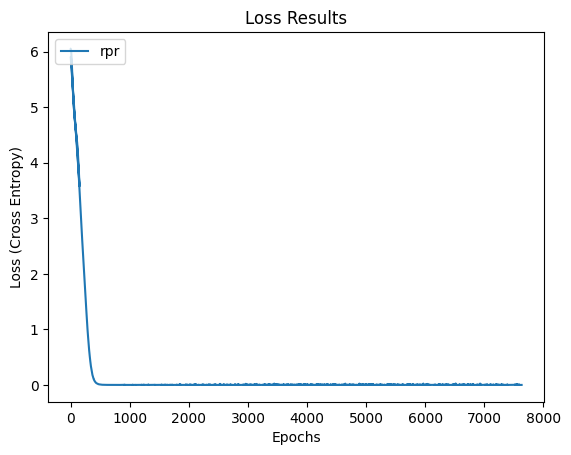

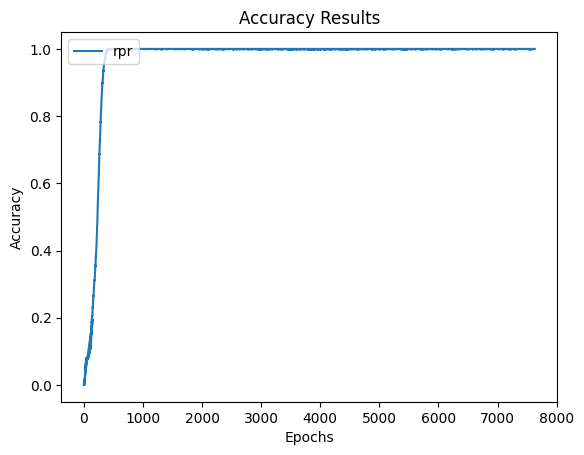

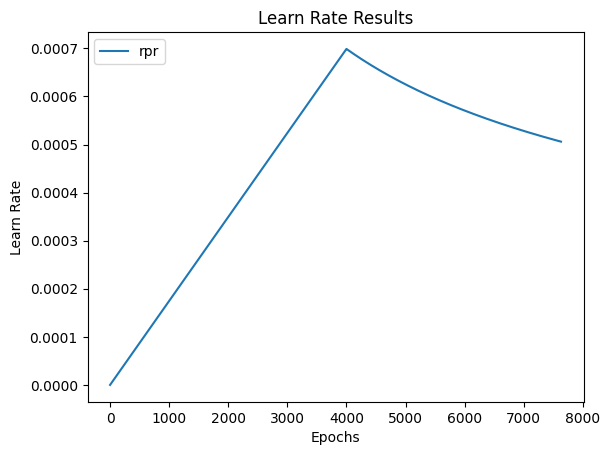

In [41]:
#@title Graph the results
import argparse
import os
import csv
import math
import matplotlib.pyplot as plt

RESULTS_FILE = "results.csv"
EPOCH_IDX = 0
LR_IDX = 1
EVAL_LOSS_IDX = 4
EVAL_ACC_IDX = 5

SPLITTER = '?'


def graph_results(input_dirs="MusicTransformer-Pytorch/rpr/results", output_dir=None, model_names=None, epoch_start=0, epoch_end=None):
    """
    ----------
    Author: Damon Gwinn
    ----------
    Graphs model training and evaluation data
    ----------
    """

    input_dirs = input_dirs.split(SPLITTER)

    if(model_names is not None):
        model_names = model_names.split(SPLITTER)
        if(len(model_names) != len(input_dirs)):
            print("Error: len(model_names) != len(input_dirs)")
            return

    #Initialize Loss and Accuracy arrays
    loss_arrs = []
    accuracy_arrs = []
    epoch_counts = []
    lrs = []

    for input_dir in input_dirs:
        loss_arr = []
        accuracy_arr = []
        epoch_count = []
        lr_arr = []

        f = os.path.join(input_dir, RESULTS_FILE)
        with open(f, "r") as i_stream:
            reader = csv.reader(i_stream)
            next(reader)

            lines = [line for line in reader]

        if(epoch_end is None):
            epoch_end = math.inf

        epoch_start = max(epoch_start, 0)
        epoch_start = min(epoch_start, epoch_end)

        for line in lines:
            epoch = line[EPOCH_IDX]
            lr = line[LR_IDX]
            accuracy = line[EVAL_ACC_IDX]
            loss = line[EVAL_LOSS_IDX]

            if(int(epoch) >= epoch_start and int(epoch) < epoch_end):
                accuracy_arr.append(float(accuracy))
                loss_arr.append(float(loss))
                epoch_count.append(int(epoch))
                lr_arr.append(float(lr))

        loss_arrs.append(loss_arr)
        accuracy_arrs.append(accuracy_arr)
        epoch_counts.append(epoch_count)
        lrs.append(lr_arr)

    if(output_dir is not None):
        try:
            os.mkdir(output_dir)
        except OSError:
            print ("Creation of the directory %s failed" % output_dir)
        else:
            print ("Successfully created the directory %s" % output_dir)

    ##### LOSS #####
    for i in range(len(loss_arrs)):
        if(model_names is None):
            name = None
        else:
            name = model_names[i]

        #Create and save plots to output folder
        plt.plot(epoch_counts[i], loss_arrs[i], label=name)
        plt.title("Loss Results")
        plt.ylabel('Loss (Cross Entropy)')
        plt.xlabel('Epochs')
        fig1 = plt.gcf()

    plt.legend(loc="upper left")

    if(output_dir is not None):
        fig1.savefig(os.path.join(output_dir, 'loss_graph.png'))

    plt.show()

    ##### ACCURACY #####
    for i in range(len(accuracy_arrs)):
        if(model_names is None):
            name = None
        else:
            name = model_names[i]

        #Create and save plots to output folder
        plt.plot(epoch_counts[i], accuracy_arrs[i], label=name)
        plt.title("Accuracy Results")
        plt.ylabel('Accuracy')
        plt.xlabel('Epochs')
        fig2 = plt.gcf()

    plt.legend(loc="upper left")

    if(output_dir is not None):
        fig2.savefig(os.path.join(output_dir, 'accuracy_graph.png'))

    plt.show()

    ##### LR #####
    for i in range(len(lrs)):
        if(model_names is None):
            name = None
        else:
            name = model_names[i]

        #Create and save plots to output folder
        plt.plot(epoch_counts[i], lrs[i], label=name)
        plt.title("Learn Rate Results")
        plt.ylabel('Learn Rate')
        plt.xlabel('Epochs')
        fig2 = plt.gcf()

    plt.legend(loc="upper left")

    if(output_dir is not None):
        fig2.savefig(os.path.join(output_dir, 'lr_graph.png'))

    plt.show()
graph_results('MusicTransformer-Pytorch/rpr/results', model_names='rpr')

To have the model continue your custom MIDI enter the following into the custom_MIDI field below:

-primer_file '/content/some_dir/some_seed_midi.mid'

For example: -primer_file '/content/MusicTransformer-Pytorch/seed.mid'

# Generate and Explore the output :)

In [43]:
#@title Generate, Plot, Graph, Save, Download, and Render the resulting output
number_of_tokens_to_generate = 1023 #@param {type:"slider", min:1, max:2048, step:1}
priming_sequence_length = 65 #@param {type:"slider", min:1, max:2048, step:8}
maximum_possible_output_sequence = 2048 #@param {type:"slider", min:0, max:2048, step:8}
select_model = "/content/MusicTransformer-Pytorch/rpr/results/best_loss_weights.pickle" #@param ["/content/MusicTransformer-Pytorch/rpr/results/best_acc_weights.pickle", "/content/MusicTransformer-Pytorch/rpr/results/best_loss_weights.pickle"]
custom_MIDI = "" #@param {type:"string"}

import processor
from processor import encode_midi, decode_midi

!python generate.py -output_dir output -model_weights='MusicTransformer-Pytorch/rpr/results/best_loss_weights.pickle' --rpr -target_seq_length=1023 -num_prime=65 -max_sequence=2048 #

print('Successfully exported the output to output folder. To primer.mid and rand.mid')

# set the src and play
FluidSynth("/content/font.sf2").midi_to_audio('/content/MusicTransformer-Pytorch/output/rand.mid', '/content/MusicTransformer-Pytorch/output/output.wav')

from google.colab import files
files.download('/content/MusicTransformer-Pytorch/output/rand.mid')
files.download('/content/MusicTransformer-Pytorch/output/primer.mid')

Audio('/content/MusicTransformer-Pytorch/output/output.wav')


HySyntaxError: parse error for pattern macro 'import': got unexpected token: hy.models.List([
  hy.models.Expression([
    hy.models.Symbol('.'),
    hy.models.Symbol('collections'),
    hy.models.Symbol('abc')]),
  hy.models.List([
    hy.models.Symbol('Iterable')])]), expected: end of input (pipeline.hy, line 1)

In [ ]:
#@title Plot and Graph the Output :)
graphs_length_inches = 18 #@param {type:"slider", min:0, max:20, step:1}
notes_graph_height = 6 #@param {type:"slider", min:0, max:20, step:1}
highest_displayed_pitch = 92 #@param {type:"slider", min:1, max:128, step:1}
lowest_displayed_pitch = 24 #@param {type:"slider", min:1, max:128, step:1}
piano_roll_color_map = "Blues"

import librosa
import numpy as np
import pretty_midi
import pypianoroll
from pypianoroll import Multitrack, Track
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use('SVG')
# For plotting
import mir_eval.display
import librosa.display
%matplotlib inline


midi_data = pretty_midi.PrettyMIDI('/content/MusicTransformer-Pytorch/output/rand.mid')

def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))



roll = np.zeros([int(graphs_length_inches), 128])
# Plot the output

track = Multitrack('/content/MusicTransformer-Pytorch/output/rand.mid', name='track')
plt.figure(figsize=[graphs_length_inches, notes_graph_height])
fig, ax = track.plot()
fig.set_size_inches(graphs_length_inches, notes_graph_height)
plt.figure(figsize=[graphs_length_inches, notes_graph_height])
ax2 = plot_piano_roll(midi_data, int(lowest_displayed_pitch), int(highest_displayed_pitch))
plt.show(block=False)

### Save to Google Drive (Standard GD connect code)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')